In [1]:
!pip install Bio

In [2]:
import numpy as np
from levitt_model.model import LevittModel
from levitt_model.potential import Potential
import Bio.PDB as pdb
from Bio.PDB.QCPSuperimposer import QCPSuperimposer

import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Часть 0

## 0.1. Напишите <a href="https://t.me/protein_course_bot">этому боту в Telegram</a>, он вернет ID 10 тестовых белков. Загрузите первый из них и откройте его:

https://projectswhynot.site/pdb-filtering/

In [3]:
pdb_ids = ["1fsd"]

In [4]:
pdb_list = pdb.PDBList()

In [5]:
path = pdb_list.retrieve_pdb_file(pdb_ids[0], file_format="pdb")

In [6]:
struct = pdb.PDBParser().get_structure("s", path)

In [7]:
chain = struct[0].child_list[0].child_list

## 0.2. Проверим применимость модели Левитта: все углы $\omega$ должны быть около $180$ грудусов. Если получится, что это не так для взятого белка, возьмите другой.

In [12]:
omegas = []

for i in range(1, len(chain)):
    # your code here
    omega = pdb.calc_dihedral(chain[i-1]["CA"].get_vector(),
                             chain[i-1]["C"].get_vector(),
                             chain[i]["N"].get_vector(),
                             chain[i]["CA"].get_vector())
    omegas += [omega]

omegas = np.array(omegas)
omegas[omegas < 0] += 2*np.pi

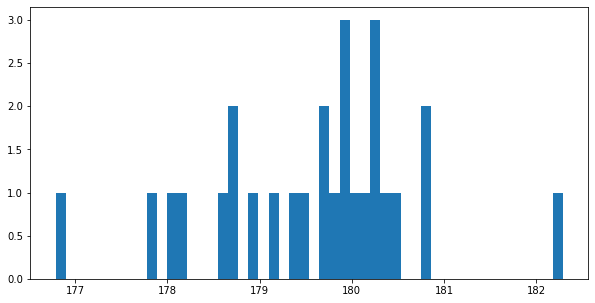

In [13]:
plt.figure(figsize=(10,5))
plt.hist(omegas/np.pi*180, bins=50)
plt.show()

# Часть 1

## 1.1. Давайте посмотрим на точность модели. Получите список названий аминокислот из цепочки; получите все оригинальные углы $\alpha_i = dihedral(C_\alpha^{i-1}, C_\alpha^{i}, C_\alpha^{i+1}, C_\alpha^{i+2})$

In [16]:
res_names = [residue.resname for residue in chain]
orig_alphas = []

# your code here
for i in range(1, len(chain)-2):
    orig_alpha = pdb.calc_dihedral(chain[i-1]["CA"].get_vector(),
                                   chain[i]["CA"].get_vector(),
                                 chain[i+1]["CA"].get_vector(),
                                  chain[i+2]["CA"].get_vector())
    orig_alphas += [orig_alpha]

In [15]:
res_names

['GLN',
 'GLN',
 'TYR',
 'THR',
 'ALA',
 'LYS',
 'ILE',
 'LYS',
 'GLY',
 'ARG',
 'THR',
 'PHE',
 'ARG',
 'ASN',
 'GLU',
 'LYS',
 'GLU',
 'LEU',
 'ARG',
 'ASP',
 'PHE',
 'ILE',
 'GLU',
 'LYS',
 'PHE',
 'LYS',
 'GLY',
 'ARG']

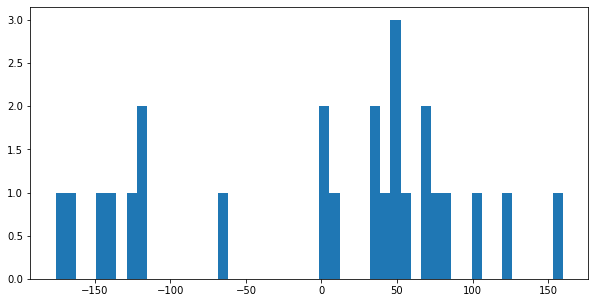

In [20]:
plt.figure(figsize=(10,5))
plt.hist(np.array(orig_alphas)/np.pi*180, bins=50)
plt.show()

Смотрим на зависимость соседних позицие - ее нет. Марковость отсутствует

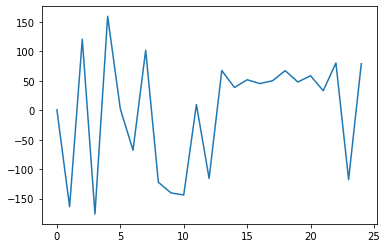

In [25]:
plt.plot(np.arange(len(chain)-3),
         np.array(orig_alphas)/np.pi *180)
plt.show()

## 1.2. Получите оригинальные координаты всех атомов $C_\alpha$; получите координаты $C_\alpha$, воспользовавшись моделью Левитта; сравните и получите точность.

In [17]:
orig_cas = np.array([residue["CA"].coord for residue in chain])

model = LevittModel('table1.csv', res_names)
pred_cas = model.dihedralsToCoords(orig_alphas)[0]

In [18]:
qsi = QCPSuperimposer()
qsi.set(orig_cas, pred_cas)
qsi.run()
print("Точность построенной модели: {}".format(qsi.rms))

Точность построенной модели: 3.220481975500713


Хороша ли модель? 🤔

# Часть 2

In [21]:
potential = Potential(res_names, model, 'vdwCoeffs.csv', 'solventCoeffs.csv', 'fourierCoeffs.csv')

## 2.1. Вычислите значения потенциала Левитта для оригинальных значений углов $\alpha$:

In [37]:
potential.calculateEnergyPotential(orig_alphas,
                                   verbose = True)

COMPONENTS:
	van der Waals and SS: 129777.31823379797
	Solvent: 93.96841348522291
	Hydrogen: 2039.3420223207618
	Non bonded: 14.507117014747852


C:\Users\Student\Desktop\potential_task\levitt_model\potential.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _, Rs, Nss, Oss = _np.array(self._model.dihedralsToCoords(alphas, self._dist_ns_os))


131925.13578661872

In [33]:
# your code here

potential.calculateEnergyPotential(np.zeros(len(orig_alphas)),
                                   verbose = True)

C:\Users\Student\Desktop\potential_task\levitt_model\potential.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _, Rs, Nss, Oss = _np.array(self._model.dihedralsToCoords(alphas, self._dist_ns_os))


COMPONENTS:
	van der Waals and SS: 3147482202809.7646
	Solvent: 243.73639197769944
	Hydrogen: 875800236.5263966
	Non bonded: 21.07199999999999


3148358003311.099

In [35]:
potential.calculateEnergyPotential(np.full(len(orig_alphas), np.pi),
                                   verbose = True)

C:\Users\Student\Desktop\potential_task\levitt_model\potential.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _, Rs, Nss, Oss = _np.array(self._model.dihedralsToCoords(alphas, self._dist_ns_os))


COMPONENTS:
	van der Waals and SS: -3.5483191426873115
	Solvent: 41.34173722993935
	Hydrogen: 11.400045324819368
	Non bonded: 4.376000000000002


53.56946341207141

**Для обсуждения**: Хорошее ли значение получилось? 🤔

Посмотрите на формулу потенциала. Как бы Вы объяснили такой результат?

Просто близко расположенные атомы

Есть большие вопросы к потенциалу!

## 2.2. Посмотрим на значения потенциала в других точках. Прежде всего, проверьте, каковы значения потенциала в 'полностью растянутой' конформации (все $\alpha = 180$) и 'полностью сжатой' (все $\alpha = 0$). Вызывайте функцию с параметром verbose=True.

In [32]:
(np.array(orig_alphas)/np.pi * 180).tolist()

[0.6611437635759694,
 -163.69005379849006,
 120.79398786082632,
 -176.06199847598867,
 159.78720055952226,
 2.2387279169656336,
 -67.76618252476322,
 102.07826387161913,
 -122.3422542308596,
 -140.41610219522852,
 -143.8728149405689,
 9.762950337081927,
 -115.6870489550105,
 67.5273820765114,
 38.758341187217155,
 51.88928218147468,
 45.42241396192713,
 50.145869681854414,
 67.34480837789786,
 48.05929599894995,
 58.67603119198777,
 33.27174357542695,
 80.3621866005143,
 -117.6096377009557,
 79.05667173763405]

Все 0:

Все 180:

Какие выводы можно сделать из этих результатов?

## 2.3. Запустим минимизацию из оригинальных значений $\alpha$. Каким будет результат?

In [39]:
potential._init_alphas = orig_alphas
minimize(potential.calculateEnergyPotential,
            method="L-BFGS-B",
            jac=potential.calculate_potential_alpha_derivative,
            x0=orig_alphas,
            bounds=[[-np.pi, np.pi]] * len(orig_alphas))

C:\Users\Student\Desktop\potential_task\levitt_model\potential.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _, Rs, Nss, Oss = _np.array(self._model.dihedralsToCoords(alphas, self._dist_ns_os))
C:\Users\Student\Desktop\potential_task\levitt_model\potential.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Cas, Rs, Nss, Oss = _np.array(self._model.dihedralsToCoords(alphas, self._dist_ns_os))
C:\Users\Student\Desktop\potential_task\levitt_model\potential.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (wh

      fun: 53.56946341207158
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([-36.08863942,   1.18396882, -35.28622006,   0.38154946,
       -34.48380071,  -0.4208699 , -33.68138135,  -1.22328925,
       -32.87896199,  -2.02570861, -32.07654263,  -2.82812797,
       -31.27412327,  -3.63054733, -30.47170392,  -4.43296669,
       -29.66928456,  -5.23538604, -28.8668652 ,  -6.0378054 ,
       -28.06444584,  -6.84022476, -27.26202648,  -7.64264412,
       -26.45960713])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 42
      nit: 1
     njev: 42
   status: 2
  success: False
        x: array([ 3.14159265,  3.14159265,  3.14159265,  3.14159265,  3.14159265,
        3.14159265,  3.14159265,  3.14159265,  3.14159265,  3.14159265,
        3.14159265,  3.14159265,  3.14159265, -3.14159265, -3.14159265,
        3.14159265, -3.14159265, -3.14159265,  3.14159265, -3.14159265,
       -3.14159265,  3.14159265, -3.14159265, -3.14159265, -3.14159265])